In [1]:
{-# LANGUAGE GeneralizedNewtypeDeriving #-}
{-# LANGUAGE TypeSynonymInstances #-}
{-# LANGUAGE FlexibleInstances #-}

import Data.Bits             (Bits (bit, complement, popCount, shiftR, (.&.), (.|.)),
                              FiniteBits (finiteBitSize))
import Data.ByteArray.Hash   (FnvHash32 (..), fnv1Hash)
import Data.ByteString.Char8 (pack)
import Data.Char             (intToDigit)
import Data.Semigroup        ((<>))
import Data.Vector           (Vector, drop, singleton, take, (!), (//))
import Data.Word             (Word16, Word32)
import Numeric               (showIntAtBase)
import Prelude               hiding (drop, lookup, take)
import System.TimeIt         (timeIt)
import Text.Show.Pretty      (pPrint)

In [2]:
newtype Binary a = Binary a deriving (Enum, Ord, Real, Integral, Eq, Num, Bits, FiniteBits)

instance (FiniteBits a, Show a, Integral a) => Show (Binary a) where
    show (Binary a) = let
        str = showIntAtBase 2 intToDigit a ""
        size = finiteBitSize a
        in replicate (size - length str) '0' <> str

In [3]:
type Hash = Binary Word32
type Bitmap = Binary Word16
type Shift = Int

class Hashable a where
    hash :: a -> Hash

In [4]:
instance Hashable String where
    hash s = let
        FnvHash32 h = fnv1Hash (pack s)
        in Binary h

In [5]:
data HAMT key value
    = None
    | Leaf Hash key value
    | Many Bitmap (Vector (HAMT key value))
    | Full (Vector (HAMT key value))
    | Coll Hash (Vector (key, value))
    deriving (Show)

empty :: HAMT key value
empty = None

In [6]:
bitsPerSubkey :: Int
bitsPerSubkey = 4

subkeyMask :: Bitmap
subkeyMask = (bit bitsPerSubkey) - 1

fullMask :: Bitmap
fullMask = (bit (2^bitsPerSubkey)) - 1

subkey :: Hash -> Shift -> Int
subkey hash shift = fromIntegral $ (fromIntegral $ shiftR hash shift) .&. subkeyMask

maskIndex :: Bitmap -> Bitmap -> Int
maskIndex bitmap mask = popCount (bitmap .&. (mask - 1))

bitMask :: Hash -> Shift -> Bitmap
bitMask hash shift = bit (subkey hash shift)

In [7]:
insertAt :: Vector a -> Int -> a -> Vector a
insertAt vector index a = take index vector <> singleton a <> drop index vector

updateAt :: Vector a -> Int -> a -> Vector a
updateAt vector index a = vector // [(index, a)]

deleteAt :: Vector a -> Int -> Vector a
deleteAt vector index = take index vector <> drop (index+1) vector

In [8]:
insert :: (Hashable key, Eq key) => key -> value -> HAMT key value -> HAMT key value
insert key value hamt = insert' 0 (hash key) key value hamt

insert' :: Eq key => Shift -> Hash -> key -> value -> HAMT key value -> HAMT key value
insert' shift hash key value None = Leaf hash key value

insert' shift hash key value leaf@(Leaf leafHash leafKey leafValue)
    | hash == leafHash =
        if key == leafKey
        then Leaf hash key value
        else Coll hash (insertAt (singleton (leafKey, leafValue)) 0 (key, value))
    | otherwise = insert' shift hash key value (Many (bitMask leafHash shift) (singleton leaf))

insert' shift hash key value (Many bitmap vector)
    | bitmap .&. mask == 0 = let
        leaf = Leaf hash key value
        vector' = insertAt vector index leaf
        bitmap' = bitmap .|. mask
        in if bitmap' == fullMask
          then Full vector'
          else Many bitmap' vector'
    | otherwise = let
        subtree = vector ! index
        subtree' = insert' (shift+bitsPerSubkey) hash key value subtree
        vector' = updateAt vector index subtree'
        in Many bitmap vector'
    where
        mask = bitMask hash shift
        index = maskIndex bitmap mask

insert' shift hash key value (Full vector) =
    let
        subtree = vector ! index
        subtree' = insert' (shift+bitsPerSubkey) hash key value subtree
        vector' = updateAt vector index subtree'
    in Full vector'
    where
        index = subkey hash shift

insert' shift hash key value coll@(Coll collHash vector)
    | hash == collHash = Coll collHash (updateOrPrepend 0 (length vector) key value vector)
    | otherwise = insert' shift hash key value (Many (bitMask collHash shift) (singleton coll))
    where
        updateOrPrepend index len key value vector
            | index == len = insertAt vector 0 (key, value)
            | otherwise = let
                (currKey, _) = vector ! index
                in if currKey == key
                    then updateAt vector index (key, value)
                    else updateOrPrepend (index+1) len key value vector

In [9]:
fromList :: (Hashable key, Eq key) => [(key, value)] -> HAMT key value
fromList = foldr (uncurry insert) empty

In [10]:
lookup :: (Hashable key, Eq key) => key -> HAMT key value -> Maybe value
lookup key hamt = lookup' 0 (hash key) key hamt

lookup' :: Eq key => Shift -> Hash -> key -> HAMT key value -> Maybe value
lookup' shift hash key None = Nothing

lookup' shift hash key (Leaf leafHash leafKey leafValue)
    | hash == leafHash && key == leafKey = Just leafValue
    | otherwise = Nothing

lookup' shift hash key (Many bitmap vector)
    | bitmap .&. mask == 0 = Nothing
    | otherwise = lookup' (shift+bitsPerSubkey) hash key (vector ! index)
    where
        mask = bitMask hash shift
        index = maskIndex bitmap mask

lookup' shift hash key (Full vector) = lookup' (shift+bitsPerSubkey) hash key (vector ! index)
    where
        index = subkey hash shift

lookup' shift hash key (Coll collHash vector)
    | hash == collHash = findMatching 0 (length vector) key vector
    | otherwise = Nothing
    where
        findMatching index len key vector
            | index == len = Nothing
            | otherwise = let
                (currKey, currValue) = vector ! index
                in if currKey == key
                    then Just currValue
                    else findMatching (index+1) len key vector

In [11]:
instance Hashable Int where
    hash int = Binary (fromIntegral int)

In [12]:
delete :: (Hashable key, Eq key) => key -> HAMT key value -> HAMT key value
delete key hamt = delete' 0 (hash key) key hamt

delete' :: Eq key => Shift -> Hash -> key -> HAMT key value -> HAMT key value
delete' shift hash key None = None

delete' shift hash key leaf@(Leaf leafHash leafKey leafValue)
    | hash == leafHash && key == leafKey = None
    | otherwise = leaf

delete' shift hash key many@(Many bitmap vector)
    | bitmap .&. mask == 0 = many
    | otherwise = let
        subtree = vector ! index
        subtree' = delete' (shift+bitsPerSubkey) hash key subtree
        in case subtree' of
            None -> if length vector == 1
                then None
                else Many (bitmap .&. complement mask) (deleteAt vector index)
            Leaf{} -> if length vector == 1
                then subtree'
                else Many bitmap (updateAt vector index subtree')
            _ -> Many bitmap (updateAt vector index subtree')
    where
        mask = bitMask hash shift
        index = maskIndex bitmap mask

delete' shift hash key (Full vector) =
    let
        subtree = vector ! index
        subtree' = delete' (shift+bitsPerSubkey) hash key subtree
    in case subtree' of
        None -> Many (fullMask .&. complement mask) (deleteAt vector index)
        _ -> Full (updateAt vector index subtree')
    where
        mask = bitMask hash shift
        index = subkey hash shift

delete' shift hash key coll@(Coll collHash vector)
    | hash == collHash = let
        vector' = deleteMatching 0 (length vector) key vector
        in if length vector' == 1
            then (\(leafKey, leafValue) -> Leaf collHash leafKey leafValue) $ vector' ! 0
            else Coll collHash vector'
    | otherwise = coll
    where
        deleteMatching index len key vector
            | index == len = vector
            | otherwise = let
                (currKey, _) = vector ! index
                in if currKey == key
                    then deleteAt vector index
                    else deleteMatching (index+1) len key vector

In [13]:
import IHaskell.Display.Graphviz
import Control.Monad.Trans.State.Strict
import Control.Monad.Trans.Writer.CPS
import Control.Monad.Trans.Class
import qualified Data.Vector as Vector
import Data.List (intercalate, intersperse, foldl')
import qualified Prelude

In [14]:
data TreeNode
    = TreeNode { nodeId :: Int, bitmap   :: String, fields :: [Int] }
    | LeafNode { leafId :: Int, leafHash :: String, leafKey :: String, leafValue :: String }
    | CollNode { collId :: Int, collHash :: String, collPairs :: [(String, String)]}
    deriving (Eq, Show)

In [15]:
getFreshId :: State Int Int
getFreshId = do
    currentId <- get
    put (currentId+1)
    pure currentId

number :: (Show k, Show v) => HAMT k v -> WriterT [TreeNode] (State Int) Int
number None = do
    tell mempty
    pure 0
number (Leaf h k v) = do
    i <- lift $ getFreshId
    tell [(LeafNode i (show h) (show k) (show v))]
    pure i
number (Many b hs) = do
    i <- lift $ getFreshId
    numbered <- Vector.toList <$> traverse number hs
    tell [(TreeNode i (show b) numbered)]
    pure i
number (Full hs) = do
    i <- lift $ getFreshId
    numbered <- Vector.toList <$> traverse number hs
    tell [(TreeNode i "FULL" numbered)]
    pure i
number (Coll h kvs) = do
    i <- lift $ getFreshId
    tell [CollNode i (show h) (map (\(k,v) -> (show k, show v)) (Vector.toList kvs))]
    pure i

nodeData :: (Show k, Show v) => HAMT k v -> [TreeNode]
nodeData = flip evalState 0 . execWriterT . number

escape = concatMap escaper
    where
        escaper :: Char -> String
        escaper c = case c of
            '"'  -> "\\\""
            '\\' -> "\\\\"
            _    -> [c]

nodeLines :: TreeNode -> [String]
nodeLines (LeafNode i h k v) = let
    label = intercalate "|" [h, k, v]
    line = ("n" ++ show i) ++ " " ++ "[label=\"" ++ escape label ++ "\"]"
    in [line]
nodeLines (CollNode i h kvs) = let
    label = intercalate "|" [h, shownKvs]
    line = ("n" ++ show i) ++ " " ++ "[label=\"" ++ escape label ++ "\"]"
    in [line]
    where
        shownKvs = intercalate "|" $ map (\(k,v) -> k ++ " : " ++ v) kvs
nodeLines (TreeNode i b fs) = let
    indices = Prelude.take (length fs) [0..]
    pairs = zip indices fs
    edges = flip map pairs $ \(f,t) -> "n" ++ show i ++ ":" ++ "f" ++ show f ++ " -> " ++ "n" ++ show t
    fields = flip map indices $ \ix -> "<f" ++ show ix ++ ">"
    label = intercalate "|" $ b:fields
    line = ("n" ++ show i) ++ " " ++ "[label=\"" ++ escape label ++ "\"]"
    in (line:edges)

makeLines = concatMap nodeLines

makeDotLines :: [String] -> String
makeDotLines = concatMap (\l -> l ++ ";\n")

preamble = unlines $
    [ "digraph {"
    , "node [shape=record];"
    , "splines=false;"
    , "ranksep=2;"
    , "nodesep=1;"
    ]
postamble = unlines $ ["}"]

makeDot :: String -> String
makeDot str = preamble ++ str ++ postamble

dotFromHAMT :: (Show k, Show v) => HAMT k v -> String
dotFromHAMT = makeDot . makeDotLines. makeLines . nodeData

Line 1: Use tuple-section
Found:
flip (,) ()
Why not:
(, ())

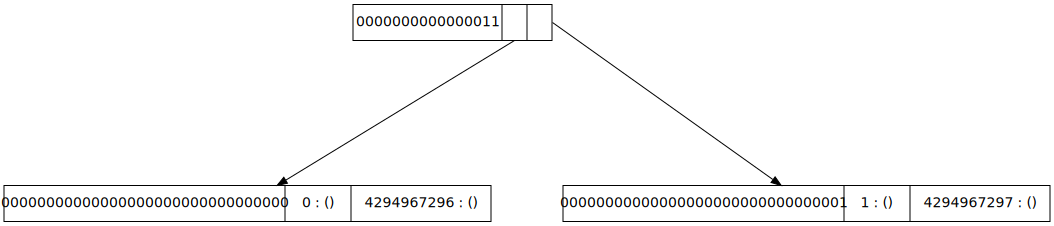

In [16]:
dot $ dotFromHAMT (fromList (map (flip (,) ()) [0, 1, 2^32, 1 + (2^32)]) :: HAMT Int ())